We're going to train an unsupervised embedding model, and then use these embeddings in a downstream binary classification model.
This means we need a train graph **without** the edges used to train or test the classification model.

In [17]:
import pandas as pd
import itertools
import statistics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import torch as th
import networkx as nx
from sklearn.model_selection import KFold
from torch_geometric.utils.convert import to_networkx, from_networkx
from sklearn.model_selection import train_test_split
import random
from torch_geometric.data import Data
from typing import Literal
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [18]:
nodes_df = pd.read_csv("../data/Nodes.csv", index_col=0).rename(columns={"category":"node_type"})
nodes_df.node_type = nodes_df.node_type.apply(lambda x: x.split(":")[1])
edges_df = pd.read_csv("../data/Edges.csv", index_col=0)
edges_df = edges_df.rename(columns={"type":"rel_type"}).dropna(subset=['rel_type', 'start_id', 'end_id']).rename(columns={"start_id":"source_id","end_id":"target_id"})
edges_df.rel_type = edges_df.rel_type.apply(lambda x: x.split(":")[1])
treatment_df = pd.read_csv("../data/Ground Truth.csv", index_col=0)
treatment_df = treatment_df.rename(columns={"source":"source_id","target":"target_id"})
edges_df['pair_id'] = edges_df.source_id + "::" + edges_df.target_id
treatment_df['pair_id'] = treatment_df.source_id + "::" + treatment_df.target_id
nodes_df['ontology'] = nodes_df.id.apply(lambda x: x.split(":")[0])

We could remove just the `biolink:treats` edge, but to ensure there's no leakage, let's remove all direct links between the drug/diseases pairs. It's interesting that so many pairs have `biolink:contraindicated_for`.  We're using biolink, where edges are hierarchical eg `has_participant` is a child predicate of `related_to`. It would be intelligent to model the ontology of the relations, rather than expecting the model to learn it...


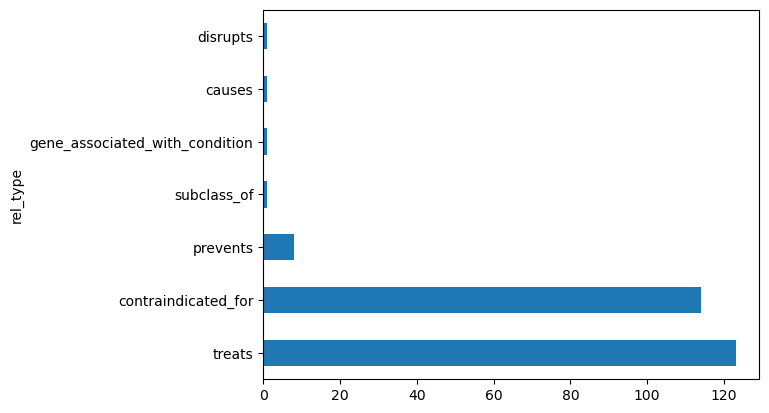

In [19]:
edges_df[edges_df.pair_id.isin(treatment_df.pair_id)].rel_type.value_counts().plot.barh()
# Remove treatment edges from the graph from which we'll build the embeddings
edges_df = edges_df[~edges_df.pair_id.isin(treatment_df.pair_id)].copy()

<Axes: ylabel='rel_type'>

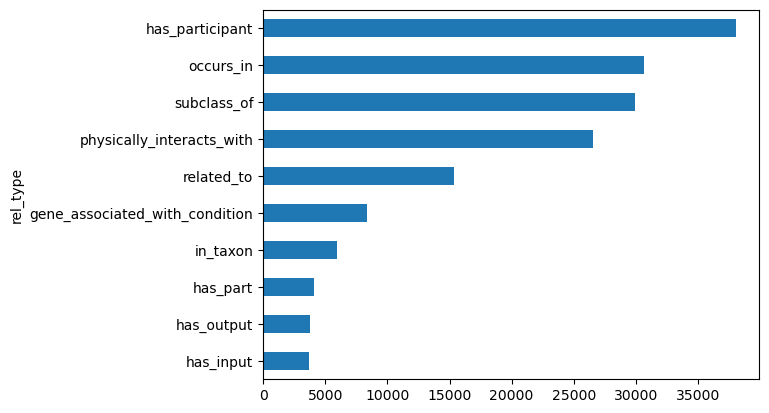

In [20]:
metaedge_type_counts = edges_df.rel_type.value_counts()
metaedge_type_counts.sort_values().tail(10).plot.barh()

Let's turn the low frequency edges to `related_to` - the highest level of biolink predicate.

In [21]:
low_frequency_edge_types = metaedge_type_counts[metaedge_type_counts<5000].index
for edge_type in low_frequency_edge_types:
    edges_df.rel_type = edges_df.rel_type.replace(edge_type, "related_to")

This ground truth dataset includes entities from multiple ontologies such as [Anti-Infective Agents, Local](https://cdek.pharmacy.purdue.edu/mesh/D000891/) and [Bile acid](https://www.ebi.ac.uk/chembl/web_components/explore/target/CHEMBL2364175). I'm not sure these would be good repurposable candidates..


<Axes: ylabel='source_ontology'>

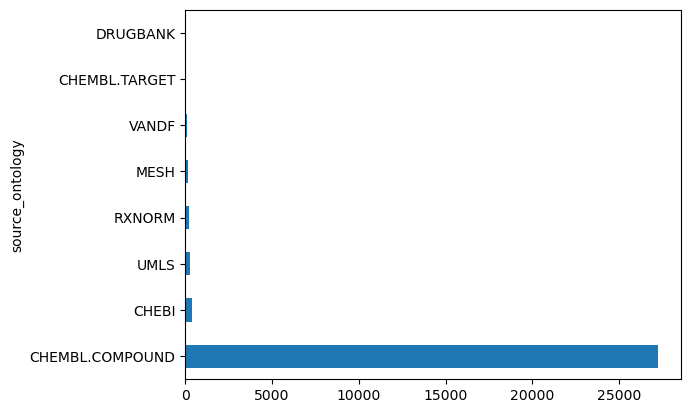

In [22]:
treatment_df['source_ontology'] = treatment_df.source_id.apply(lambda x: x.split(":")[0])
treatment_df['target_ontology'] = treatment_df.target_id.apply(lambda x: x.split(":")[0])
treatment_df['source_ontology'].value_counts().plot.barh()

<Axes: ylabel='target_ontology'>

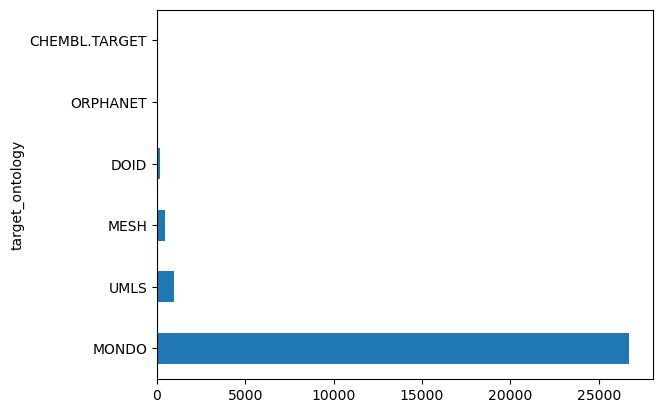

In [23]:
treatment_df['target_ontology'].value_counts().plot.barh()

Let's look at the distribution of node and edge tpyes

<Axes: ylabel='node_type'>

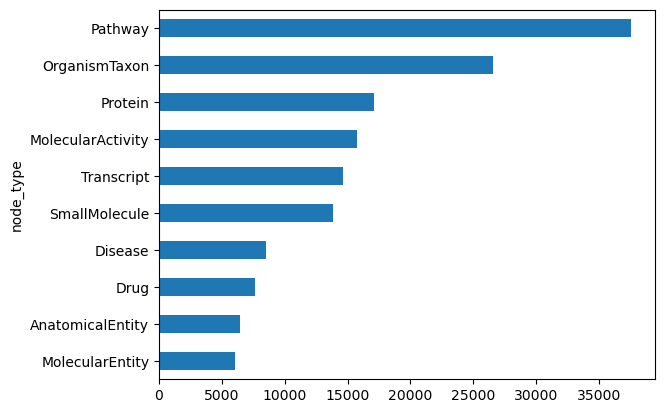

In [24]:
nodes_df.node_type.value_counts().sort_values().tail(10).plot.barh()

In [25]:
nodes_df.node_type = nodes_df.node_type.replace("Drug", "Molecule")
nodes_df.node_type = nodes_df.node_type.replace("SmallMolecule", "Molecule")

id2nodetype = dict(zip(nodes_df.id, nodes_df.node_type))
edges_df['source_node_type'] = edges_df['source_id'].apply(id2nodetype.get)
edges_df['target_node_type'] = edges_df['target_id'].apply(id2nodetype.get)

Let's only keep the most frequent and most common biological entities, and only metaedges that have over 50 occurences.

In [26]:
# node_types_to_keep = ['Protein','Disease','Molecule', 'Pathway']
node_types_to_keep = ['Disease','Molecule', "Protein"]


nodes_df = nodes_df[nodes_df.node_type.isin(node_types_to_keep)].copy()

edges_df['edge_type'] = edges_df.source_node_type + "::" + edges_df.rel_type + "::" + edges_df.target_node_type
edge_type_counts = edges_df.edge_type.value_counts()
edges_df= edges_df[edges_df.edge_type.isin(edge_type_counts[edge_type_counts>50].index)]

In [27]:
# Make sure the edges and treatment edges only contain our filtered nodes
for i in range(10):
    edges_df = edges_df[(edges_df.source_id.isin(nodes_df.id)) & (edges_df.target_id.isin(nodes_df.id))]
    # Nodes must have a degree >= 1
    nodes_df = nodes_df[nodes_df.id.isin(edges_df.source_id.tolist()+edges_df.target_id.tolist())]
    treatment_df = treatment_df[treatment_df.source_id.isin(nodes_df.id)]
    treatment_df = treatment_df[treatment_df.target_id.isin(nodes_df.id)]



In [28]:
G = nx.MultiDiGraph()
for index, row in tqdm(nodes_df.iterrows(),total=len(nodes_df)):
    G.add_node(row['id'], id=row['id'], name=row['name'], node_type=row['node_type'])

# Add edges with attributes (multiple edges between same nodes allowed)
for index, row in tqdm(edges_df.iterrows(),total=len(edges_df)):
    G.add_edge(row['source_id'], row['target_id'],
               rel_type=row['rel_type'],
               edge_type=row['edge_type'],
               source_node_type=row['source_node_type'],
               target_node_type=row['target_node_type'])


  0%|          | 0/34446 [00:00<?, ?it/s]

  0%|          | 0/51652 [00:00<?, ?it/s]

In [29]:
class SequenceEncoder:
    def __init__(self, model_name='Charangan/MedBERT', embedding_dim=768):
        self.device = 'cuda' if th.cuda.is_available() else 'cpu'
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.embedding_dim = embedding_dim # Can definitely find this from the model

    def embed(self, names):
        # Try primary name and alternative names for each entity until you find a string that can parse.
        # Only a few molecules fair to the primary name being their IUPAC.
        for name in names:
            try:
                input_tokens = self.tokenizer(name, return_tensors="pt").to(self.device)
                outputs = self.model(**input_tokens)
                embedding = outputs.last_hidden_state[0, 0, :]
                return embedding, True
            except:
                continue
        embedding = th.zeros(self.embedding_dim).to(self.device)
        return embedding, False
            

    def __call__(self, all_names):
        self.failed_idxs = []
        with th.no_grad():
            embeddings = []
            for i, _all_names in tqdm(enumerate(all_names), total=len(all_names)):
                embedding, success = self.embed(_all_names)
                embeddings.append(embedding)
                if not success:
                   self.failed_idxs.append(i) 
        x = th.stack(embeddings)
        return x.cpu()  # Return on CPU if further processing on GPU is not needed

In [30]:
from transformers import AutoConfig, AutoModel, AutoTokenizer
seq = SequenceEncoder()
data = from_networkx(G)

# Add NER embeddings
nodes_df['all_names'] = nodes_df.apply(lambda row: [row['name'], *str(row.all_names).split("ǂ")], axis=1)
seq_emb = seq(nodes_df.all_names.tolist())
data.x = seq_emb 
nodeid_2_ix = dict(zip(list(G.nodes()), np.arange(G.number_of_nodes())))

# Add treatment edges
treatment_df['source_idx'] = treatment_df.source_id.apply(nodeid_2_ix.get)
treatment_df['target_idx'] = treatment_df.target_id.apply(nodeid_2_ix.get)
data.y = th.tensor(treatment_df.y.values, dtype=th.long)
data.treatment_edge_index = th.tensor(treatment_df[['source_idx','target_idx']].values).T



  0%|          | 0/34446 [00:00<?, ?it/s]

In [31]:
def make_splits(data: Data, method: Literal=['random', 'molecule','disease'], num_splits = 5) -> Data:
    mask = np.zeros((num_splits, len(data.y)))
    match method:
        case "random":
            # Random split
            for i in range(num_splits):
                train_idx, val_idx = train_test_split(list(range(len(data.y))), test_size=0.10)
                mask[i, train_idx]= True

        case "molecule":
            # Leave molecule out
            for j in range(num_splits):
                train_molecule_ids = random.choices(treatment_df.source_id.tolist(), k=int(0.8*treatment_df.source_id.nunique()))
                train_mask = treatment_df.source_id.isin(train_molecule_ids).values
                mask[j, :] = train_mask
        case "disease":     
            # Leave drug out
            for k in range(num_splits):
                train_disease_ids = random.choices(treatment_df.target_id.tolist(), k=int(0.8*treatment_df.target_id.nunique()))
                train_mask = treatment_df.target_id.isin(train_disease_ids).values
                mask[k, :] = train_mask
    
    data.train_mask = th.tensor(mask).bool()
    return data

In [32]:
emb_df = pd.read_csv("../data/Embeddings.csv")
nodes_df = nodes_df.merge(emb_df[['id','topological_embedding']], on='id')
nodes_df.topological_embedding = nodes_df.topological_embedding.apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
data.x_pretrained = th.tensor(np.stack(nodes_df.topological_embedding.values))
data = make_splits(data, method='random')
nodes_df.to_csv("../data/nodes.csv", index=False)
edges_df.to_csv("../data/edges.csv", index=False)
treatment_df.to_csv("../data/treatment.edges.csv", index=False)
th.save(G, "../data/graph.pt")
th.save(data,"../data/data.pt")